# **1. Install packages**

In [1]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download&id={}"
    session = requests.Session()
    response = session.get(URL.format(id), stream=True)
    token = get_confirm_token(session, response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL.format(id), params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(session, response):
    for key, value in response.cookies.items():
        if key.startswith('download'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

# Replace 'YOUR_FILE_ID' with the actual file ID from the Google Drive link
# The file ID is the string after '/d/' and before '/view' in the URL
file_id = '1vfIhvWgS_9AePzEQQ-ct93WSd9iiP-3c'
destination = 'data_stress.csv'
download_file_from_google_drive(file_id, destination)

print(f"Downloaded {destination}")

Downloaded data_stress.csv


# **2. Load libraries**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimpy import skim

In [3]:
import sys
try:
    import scipy
    scipy_version = scipy.__version__
except ImportError:
    scipy_version = "Not installed"

try:
    import statsmodels
    statsmodels_version = statsmodels.__version__
except ImportError:
    statsmodels_version = "Not installed"

print(f"Python version: {sys.version}")
print(f"SciPy version: {scipy_version}")
print(f"Statsmodels version: {statsmodels_version}")

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
SciPy version: 1.16.1
Statsmodels version: 0.14.5


In [4]:
import statsmodels.api as sm
print("Statsmodels imported successfully!")

Statsmodels imported successfully!


# **3. Load data**

In [5]:
#data = pd.read_csv("C:/Users/asus/OneDrive/Desktop/projectfinal2025/data_stress.csv")
#data
# Load the downloaded CSV file into a pandas DataFrame
data = pd.read_csv('data_stress.csv')

# Display the first few rows of the DataFrame
display(data.head())

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate,Stress Levels
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


# **4. EDA**

In [6]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 630    │ │ float64     │ 8     │                                                          │
│ │ Number of columns │ 9      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column            ┃ NA  ┃ NA %               ┃ mean  ┃ sd    ┃ p0 ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ snoring range     │   0 │                  0 │  71.6 │ 19.37 │ 45 │  52.5 │    70 │ 91.25 │   100 │ █▄▃▃▃▇ │  │
│ │ respiration rate  │   0 │                  0 │ 21.92 │ 4.336 │ 16 │  18.5 │ 21.02 │ 25.06 │ 48.56 │  █▄▂   │  │
│ │ body temperature  │  16 │ 2.5396825396825395 │ 93.47 │ 6.833 │ 85 │ 90.58 │ 93.08 │  95.6 │ 166.2 │   █    │  │
│ │ limb movement     │  12 │ 1.9047619047619047 │ 11.95 │ 5.001 │  4 │ 8.516 │ 11.05 │ 15.95 │  46.8 │  █▆▁   │  │
│ │ blood oxygen      │   4 │ 0.6349206349206349 │ 91.05 │ 4.892 │ 82 │ 88.48 │    91 │ 94.27 │ 154.3 │   █▃   │  │
│ │ eye movement      │  18 │  2.857142857142857 │ 88.96 │ 13.48 │ 60 │ 81.23 │ 90.08 │ 98.89 │ 185.4 │  ▃█▂   │  │
│ │ hours of sleep    │  11 │  1.746031746031746 │ 3.836 │ 3.341 │  0 │ 0.472 │ 3.608 │ 6.592 │ 20.22 │  █▅▄   │  │
│ │ heart rate        │  24 │ 3.8095238095238093 │  64.9 │ 11.26 │ 50 │ 56.21 │ 62.54 │ 72.74 │ 158.7 │   █▄   │  │
│ │ Stress Levels     │   0 │                  0 │     2 │ 1.415 │  0 │     1 │     2 │     3 │     4 │ ██ ███ │  │
│ └───────────────────┴─────┴────────────────────┴───────┴───────┴────┴───────┴───────┴───────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [7]:
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" ", "_")
data.columns

Index(['snoring_range', 'respiration_rate', 'body_temperature',
       'limb_movement', 'blood_oxygen', 'eye_movement', 'hours_of_sleep',
       'heart_rate', 'Stress_Levels'],
      dtype='object')

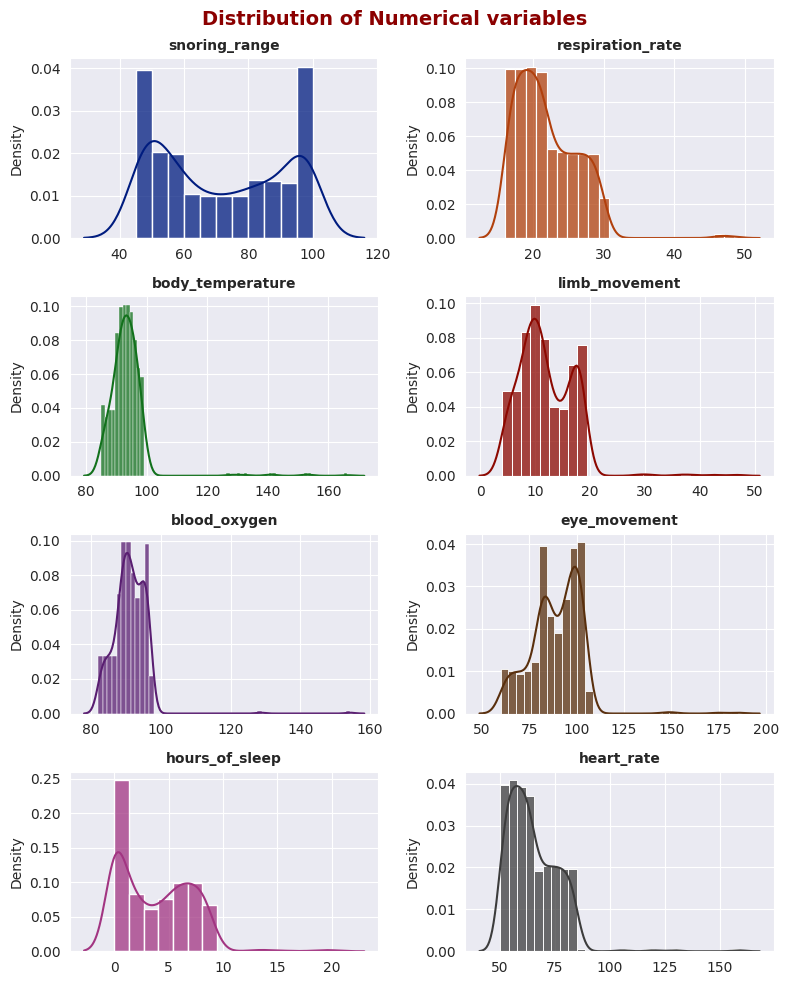

In [8]:
sns.set_style("darkgrid")
numerical_features = data.columns[:-1]
colors = sns.color_palette(n_colors = len(numerical_features), palette = 'dark')

fig,axs = plt.subplots(nrows = 4, ncols = 2, figsize = (8, 10))
axs = axs.flat

for i,feature in enumerate(numerical_features):
    sns.histplot(data = data, x = feature, stat = 'density', ax = axs[i], color = colors[i])
    sns.kdeplot(data = data, x = feature, ax = axs[i], color = colors[i])
    axs[i].set_title(f'{feature}', fontsize = 10, fontweight = 'bold')
    axs[i].set_xlabel("")
fig.suptitle("Distribution of Numerical variables", fontsize = 14, fontweight = 'bold', color = 'darkred')
fig.tight_layout()
fig.show()

# **5. Data preprocessing**

In [9]:
# Handle missing values by filling numerical missing values with the mean
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col] = data[col].fillna(data[col].mean())

print("\nMissing values after imputation:")
print(data.isnull().sum())

# Handle outliers by capping using the 99th percentile
for col in ['body_temperature', 'blood_oxygen', 'eye_movement', 'heart_rate']:
    upper_limit = data[col].quantile(0.99)
    data[col] = data[col].clip(upper=upper_limit)

print("\nData after capping outliers:")
print(data.describe())

# Separate features (X) and target (y)
X = data.drop('Stress_Levels', axis=1)
y = data['Stress_Levels']

# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeatures after scaling:")
print(X_scaled_df.head())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

print("\nShape of training and testing data:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Missing values after imputation:
snoring_range       0
respiration_rate    0
body_temperature    0
limb_movement       0
blood_oxygen        0
eye_movement        0
hours_of_sleep      0
heart_rate          0
Stress_Levels       0
dtype: int64

Data after capping outliers:
       snoring_range  respiration_rate  body_temperature  limb_movement  \
count     630.000000        630.000000        630.000000     630.000000   
mean       71.600000         21.916314         93.293093      11.945188   
std        19.372833          4.336242          5.312777       4.953314   
min        45.000000         16.000000         85.000000       4.000000   
25%        52.500000         18.500000         90.660000       8.564000   
50%        70.000000         21.016000         93.208000      11.144000   
75%        91.250000         25.064000         95.532000      15.830000   
max       100.000000         48.560000        129.163400      46.800000   

       blood_oxygen  eye_movement  hours_of_sleep

# **6. Models**

In [10]:
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
cb = CatBoostClassifier(random_state=42, verbose=0)

MODELS = [xgb, lgbm, cb]

In [11]:
from lightgbm import early_stopping
from lightgbm import log_evaluation

for model in MODELS:
    model_name = type(model).__name__
    print(f"\nTraining {model_name}...")
    if model_name == 'LGBMClassifier':
      model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                callbacks=[early_stopping(10, verbose=False), log_evaluation(period=10)])
    else:
      model.fit(X_train, y_train)
    print(f"{model_name} training complete.")


Training XGBClassifier...
XGBClassifier training complete.

Training LGBMClassifier...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 504, number of used features: 8
[LightGBM] [Info] Start training from score -1.587847
[LightGBM] [Info] Start training from score -1.597603
[LightGBM] [Info] Start training from score -1.637609
[LightGBM] [Info] Start training from score -1.617406
[LightGBM] [Info] Start training from score -1.607456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

The winning model was CatBoostClassifier, so on this model we will calculate the confusion matrices.

# **7. Model Evaluation**


Evaluating LGBMClassifier...
Metrics for LGBMClassifier:
  Accuracy: 0.9841
  Precision: 0.9847
  Recall: 0.9841
  F1 Score: 0.9839

  Confusion Matrix:


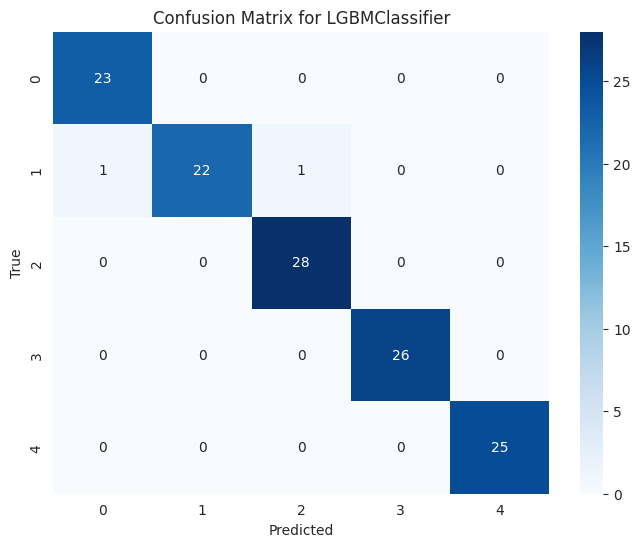


  Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.92      0.96        24
           2       0.97      1.00      0.98        28
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           0.98       126
   macro avg       0.98      0.98      0.98       126
weighted avg       0.98      0.98      0.98       126



In [12]:
for model in [lgbm]:
    model_name = type(model).__name__
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Metrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    # Display confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    print("\n  Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\n  Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

In [13]:
import pickle
import os

# Define the directory to save the model
model_dir = '/content/models'
os.makedirs(model_dir, exist_ok=True)

# Define the path to save the model file
model_path = os.path.join(model_dir, "questionar_stress_model.pkl")

# Save the CatBoost model
with open(model_path, "wb") as f:
    pickle.dump(cb, f)

print(f"LGBMClassifier: model saved successfully to {model_path}")

LGBMClassifier: model saved successfully to /content/models/questionar_stress_model.pkl


In [ ]:
import pandas as pd
import io

# Provided data as a string
data_string = """index,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate
0,93.8,25.68,91.84,16.6,89.84,99.6,1.84,74.2
1,91.64,25.104,91.552,15.88,89.552,98.88,1.552,72.76
2,60.0,20.0,96.0,10.0,95.0,85.0,7.0,60.0
3,85.76,23.536,90.768,13.92,88.768,96.92,0.768,68.84
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12"""


data_to_predict_df = pd.read_csv(io.StringIO(data_string), sep=',')

# Clean up column names by removing trailing whitespace
data_to_predict_df.columns = data_to_predict_df.columns.str.strip()

# Remove the 'index' column as it is not a feature
if 'index' in data_to_predict_df.columns:
    data_to_predict_df = data_to_predict_df.drop('index', axis=1)


# Replace spaces in column names with underscores to match training data
data_to_predict_df.columns = data_to_predict_df.columns.str.replace(" ", "_")


print("Data to predict DataFrame:")
display(data_to_predict_df)

# Preprocess the data using the same steps as the training data
# Handle missing values
for col in data_to_predict_df.columns:
    if data_to_predict_df[col].dtype in ['float64', 'int64']:
        data_to_predict_df[col] = data_to_predict_df[col].fillna(data_to_predict_df[col].mean())

# Handle outliers (assuming the same columns as in training)
for col in ['body_temperature', 'blood_oxygen', 'eye_movement', 'heart_rate']:
    # Check if column exists before trying to process it
    if col in data_to_predict_df.columns:
        upper_limit = data_to_predict_df[col].quantile(0.99)
        data_to_predict_df[col] = data_to_predict_df[col].clip(upper=upper_limit)
    else:
        print(f"Warning: Column '{col}' not found in the provided data.")


X_train_cols = X_train.columns # Get the column order from the training data
data_to_predict_df_ordered = data_to_predict_df[X_train_cols]


data_to_predict_scaled = scaler.transform(data_to_predict_df_ordered)
data_to_predict_scaled_df = pd.DataFrame(data_to_predict_scaled, columns=X_train_cols)

print("\nData to predict after preprocessing:")
display(data_to_predict_scaled_df)

# Load the saved model and make predictions
try:
    with open(model_path, "rb") as f:
        loaded_model = pickle.load(f)
    print("\nModel loaded successfully!")

    predictions = loaded_model.predict(data_to_predict_scaled_df)
    print("\nPredictions on the provided data:")
    display(predictions)

except FileNotFoundError:
    print(f"Error: The model file '{model_path}' was not found. Please ensure the model is saved correctly.")
except Exception as e:
    print(f"An error occurred while loading the model or making predictions: {e}")

Data to predict DataFrame:


,snoring_range,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,hours_of_sleep,heart_rate
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12



Data to predict after preprocessing:


,snoring_range,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,hours_of_sleep,heart_rate
0,1.146845,0.868650,-0.273726,0.940484,-0.273196,0.929211,-0.603063,0.969966
1,1.035260,0.735710,-0.327979,0.795011,-0.346989,0.870745,-0.690089,0.829076
2,-0.599252,-0.442281,0.509914,-0.393016,1.048940,-0.303306,0.956160,-0.471378
3,0.731501,0.373820,-0.475665,0.399002,-0.547872,0.704957,-0.926995,0.429564
4,-1.212970,-1.077436,0.848446,-1.100984,1.355922,-1.362321,1.333274,-1.172564



Model loaded successfully!

Predictions on the provided data:


array([[3],
       [3],
       [1],
       [3],
       [0]])

In [19]:
import pickle
import os

# Define the directory to save the model
model_dir = '/content/models'
os.makedirs(model_dir, exist_ok=True)

# Define the path to save the model file
model_path = os.path.join(model_dir, "questionar_stress_model.pkl")

# Save the CatBoost model
with open(model_path, "wb") as f:
    pickle.dump(cb, f)

print(f"LGBMClassifier: model saved successfully to {model_path}")

LGBMClassifier: model saved successfully to /content/models/questionar_stress_model.pkl
